# Project 2: Ames Housing Saleprice Prediction

---

#### 04: <b>Production Model and Insights</b>

### Contents:
- [Imports and functions](#Library-and-data-import)
- [Examine the Data](#Examine-the-data)
- [Model Preparation](#Model-Preparation)
- [Model Evaluation](#Model-Evaluation)
- [Production Model](#Production-Model)
- [Inferential Visualizations](#Inferential-Visualizations)
- [Kaggle Submission](#Kaggle-Submission)
- [Interpretation and insights](#Interpretation-and-insights)

## Library and data import

In [1]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,\
RidgeCV, LassoCV, ElasticNetCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import skew, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

In [2]:
# import cleaned training data
train_model = pd.read_csv('../datasets/train_final_dummy.csv')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Functions for modeling

In [3]:
# cross validating test data
def run_cv_test(xtest, ytest):
    # baseline model
    base_cv_scores = cross_val_score(dummy_regressor, xtest, ytest, cv= 10)
    base_cv_mse = -cross_val_score(dummy_regressor, xtest, ytest,cv=10, scoring ='neg_mean_squared_error')
    print(f'Baseline R2: {np.mean(base_cv_scores)}')
    print(f'Baseline RMSE: {np.sqrt(base_cv_mse.mean())}')
    
    # linear regression
    lr_cv_scores = cross_val_score(lr, xtest, ytest, cv= 10)
    lr_cv_mse = -cross_val_score(lr, xtest, ytest,cv=10, scoring ='neg_mean_squared_error')
    print(f'Linear R2: {np.mean(lr_cv_scores)}')
    print(f'Linear RMSE: {np.sqrt(lr_cv_mse.mean())}')
    
    # ridge regression
    ridge_cv_scores = cross_val_score(ridge, xtest, ytest, cv=10)
    ridge_cv_mse = -cross_val_score(ridge, xtest, ytest,cv=10, scoring ='neg_mean_squared_error')
    print(f'Ridge R2: {np.mean(ridge_cv_scores)}')
    print(f'Ridge RMSE: {np.sqrt(ridge_cv_mse.mean())}')
    
    # lasso regression
    lasso_cv_scores = cross_val_score(lasso, xtest, ytest, cv=10)
    lasso_cv_mse = -cross_val_score(lasso, xtest, ytest,cv=10, scoring ='neg_mean_squared_error')
    print(f'Lasso R2: {np.mean(lasso_cv_scores)}')
    print(f'Lasso RMSE: {np.sqrt(lasso_cv_mse.mean())}')
    
    # elastic net regression
    enet_cv_scores = cross_val_score(enet, xtest, ytest, cv=10)
    enet_cv_mse = -cross_val_score(enet, xtest, ytest,cv=10, scoring ='neg_mean_squared_error')
    print(f'Enet R2: {np.mean(enet_cv_scores)}')
    print(f'Enet RMSE: {np.sqrt(enet_cv_mse.mean())}')


## Model Preparation
---

### Train Test Split

we will be training more than testing as this is essentially a training dataset.

In [4]:
# create X and y (i.e. input & output variables) for modeling
features = [col for col in train_model._get_numeric_data().columns if col != 'saleprice']
X = train_model[features]
y = train_model['saleprice']

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

### Scaling

To achieve high performances with our models, scaling is required.

StandardScaler accomplishes this by using two operations:
- Centering: subtract the mean from each value in the distribution.
- Scaling: divide each result by the standard deviation.

Many elements used in the objective function of a learning algorithm assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [6]:
# scaling (i.e. standardizing)
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Hyperparameter tuning

#### Optimal value for Ridge Regression $\alpha$

In [7]:
ridge_alphas = np.logspace(0,5,200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv = 10)
optimal_ridge.fit(X_train_scaled, y_train)

print(f'Optimal ridge alpha: {optimal_ridge.alpha_}')

Optimal ridge alpha: 60.80224261649424


#### Optimal value for Lasso Regression $\alpha$

In [8]:
optimal_lasso = LassoCV(n_alphas=500, cv = 10)
optimal_lasso.fit(X_train_scaled, y_train)

print(f'Optimal lasso alpha: {optimal_lasso.alpha_}')

Optimal lasso alpha: 0.0010007904133900875


#### Optimal value for Elastic Net Regression  $\alpha$  & L1 ratio

In [9]:
l1_ratios = np.arange(0.5,1.0,0.005)

optimal_enet = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 50, cv=10)
optimal_enet.fit(X_train_scaled, y_train)

print(f'Optimal enet alpha: {optimal_enet.alpha_}')
print(f'Optimal enet L1 ratio: {optimal_enet.l1_ratio_}')

Optimal enet alpha: 0.0021293311081840693
Optimal enet L1 ratio: 0.5


## Model Evaluation
---

Summary of results below:

| Regression Model 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
|Train - baseline|-0.00200|79291.93
|Test - baseline| -0.06356|79215.86
|Train - linear|0.88826|26406.77|
|Test - linear|-5.52393669615856e+22|1.5319209953833976e+16|
|Train - ridge|0.88881|26342.37|
|Test - ridge|0.85957|26783.33|
|Train - lasso|0.89004|26177.93|
|Test - lasso|0.85472|26934.17|
|Train - elastic net|0.87921|27500.77|
|Test - elastic net|0.86177|27411.64|


Based on the scores returned using our `train_model` dataset, our **Lasso model performed the best** by having the lowest RMSE (our primary evaluation metric). There was also no significant variance between training and test data, indicating an absence of overfitting.

We did note that the ordinary linear regression performed reasonably well in the train dataset but extremely poor in the test data set. Hence, a sign of overfitting. This may be due to the large number of features (89 features) involved and only approximately 2000 observations, causing a overly complex model with irrelevant features and multicollinearity of independent variables.

Therefore, it is within expectation that regularized models performed significantly better compared to an ordinary linear regression, due to the penalty term which minimises coefficients of irrelevant features until it reaches 0 (Lasso) or close to zero (Ridge).

### Instantiate Models

Using optimal hyperparameters calculated earlier.

In [10]:
dummy_regressor = DummyRegressor()

In [11]:
lr = LinearRegression()

In [12]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

In [13]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

In [14]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

### Cross Validation - training

Evaluate models using `cross_val_score` in the following order:

    - Baseline Regression Model
    - Linear Regression Model
    - Ridge Regression Model
    - Lasso Regression Model
    - Elastic Net Regression Model

In [15]:
# baseline model
base_cv_scores = cross_val_score(dummy_regressor, X_train_scaled, y_train, cv= 10)
base_cv_mse = -cross_val_score(dummy_regressor, X_train_scaled, y_train,cv=10, scoring ='neg_mean_squared_error')

print(f'R2: {np.mean(base_cv_scores)}')
print(f'RMSE: {np.sqrt(base_cv_mse.mean())}')

R2: -0.0024099915872362264
RMSE: 0.41713388362282117


In [16]:
# linear regression
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv= 10)
lr_cv_mse = -cross_val_score(lr, X_train_scaled, y_train,cv=10, scoring ='neg_mean_squared_error')

print(f'R2: {np.mean(lr_cv_scores)}')
print(f'RMSE: {np.sqrt(lr_cv_mse.mean())}')

R2: 0.8872020633707998
RMSE: 0.1406469591947903


In [17]:
# ridge regression
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=10)
ridge_cv_mse = -cross_val_score(ridge, X_train_scaled, y_train,cv=10, scoring ='neg_mean_squared_error')

print(f'R2: {np.mean(ridge_cv_scores)}')
print(f'RMSE: {np.sqrt(ridge_cv_mse.mean())}')

R2: 0.896803967798211
RMSE: 0.13391560781808426


In [18]:
# lasso regression CV
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=10)
lasso_cv_mse = -cross_val_score(lasso, X_train_scaled, y_train,cv=10, scoring ='neg_mean_squared_error')

print(f'R2: {np.mean(lasso_cv_scores)}')
print(f'RMSE: {np.sqrt(lasso_cv_mse.mean())}')

R2: 0.8972295161597005
RMSE: 0.13364910293531698


In [19]:
# elastic net regression
enet_cv_scores = cross_val_score(enet, X_train_scaled, y_train, cv=10)
enet_cv_mse = -cross_val_score(enet, X_train_scaled, y_train,cv=10, scoring ='neg_mean_squared_error')

print(f'R2: {np.mean(enet_cv_scores)}')
print(f'RMSE: {np.sqrt(enet_cv_mse.mean())}')

R2: 0.8972362078153031
RMSE: 0.13364541552820247


### Cross Validation - test

We will now evaluate our models on the 20% test size from the `train_model` dataframe.

In [20]:
run_cv_test(X_test_scaled, y_test)

Baseline R2: -0.06021249448828583
Baseline RMSE: 0.3884743890335135
Linear R2: -1.501569363588279e+23
Linear RMSE: 146107638917.68344
Ridge R2: 0.8887557911468896
Ridge RMSE: 0.1222176481412688
Lasso R2: 0.8882404960349591
Lasso RMSE: 0.12171458368367744
Enet R2: 0.8885748812409832
Enet RMSE: 0.12151714630961197


## Fitting and evaluating our Lasso model
---

Using our best model evaluated earlier (i.e. Lasso Regression model). We will now be fitting our model and evaluating R^2 & RMSE scores based **predicted saleprice**.


- Find the R^2 and RMSE of Lasso model (non cross-val-scores i.e. **non-estimated scores**).

In [21]:
# fit training data to lasso model
lasso.fit(X_train_scaled,y_train)

Lasso(alpha=0.0010007904133900875)

In [22]:
# calculate R^2 (non-CVS)
print("Training R2(Lasso) ", lasso.score(X_train_scaled,y_train))
print("Testing R2(Lasso):", lasso.score(X_test_scaled,y_test))

Training R2(Lasso)  0.9150627302112323
Testing R2(Lasso): 0.9109854926866549


In [23]:
# calculate RMSE (non-CVS)
print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(np.exp(y_train), np.exp(lasso.predict(X_train_scaled)))))
print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lasso.predict(X_test_scaled)))))

Training RMSE(Lasso): 20812.262195370597
Testing RMSE(Lasso): 21898.643846489165


### Inferential Visualizations

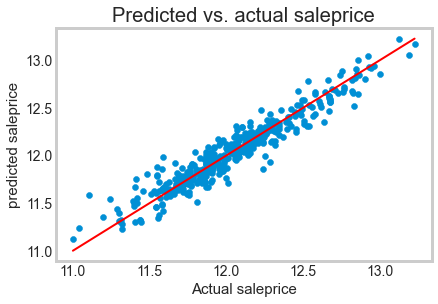

In [24]:
# scatterplot to show predicted saleprice versus actual saleprice

# find y_pred
lasso_y_pred = lasso.predict(X_test_scaled)
plt.scatter(y_test, lasso_y_pred)

p1 = max(max(y_test), max(lasso_y_pred))
p2 = min(min(y_test), min(lasso_y_pred))
plt.plot([p1, p2], [p1, p2], color = 'red', linewidth = 2)
plt.title('Predicted vs. actual saleprice')
plt.xlabel('Actual saleprice', fontsize=15)
plt.ylabel('predicted saleprice', fontsize=15)
plt.grid(False)
plt.show()

Overall the model had performed well with the line of best fit passing through most of the points, with no noticeable outliers as well. This could be said that the predicted saleprice is reasonably close to that of the actual saleprice.

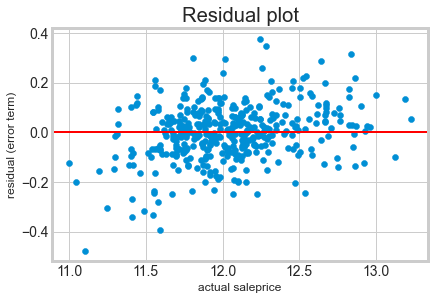

In [25]:
# find residuals
lasso_resid = y_test - lasso_y_pred

# plot residuals
plt.scatter(y_test, lasso_resid)
plt.axhline(0, linestyle='-', color='r', linewidth = 2)
plt.title('Residual plot')
plt.ylabel('residual (error term)', fontsize=12)
plt.xlabel('actual saleprice', fontsize=12)
plt.show()


One assumption of linear regression is **homoscedasticity**.

Homoscedasticity in a model means that the error is constant along the values of the dependent variable (i.e. saleprice). Looking at the residual plot above, our residuals are fairly equally distributed across actual saleprice. Hence, we can conclude that our assumption holds true and our model is performing well.

## Production Model
---

With 88 independent variables currently in our Lasso model, our model is still fairly complex and hard to interpret. Hence, in order to simplify and increase interpretability of our model, so that we could present findings to management, we will be taking the **top 28 features** (i.e. absolute coefficients > 0.009) **for our production model**.

### Interpreting Coefficients

Generally, feature coefficients can be interpreted as Œ≤1 in the following linear regression equation: 

$$y = \beta_0 + \beta_1 x_1$$

Here, Œ≤1 represents the slope (i.e. coefficient) of the independent variable, which affects the predicted value of Y. In other words, for every 1 unit change in $x_1$, our target variable `saleprice` will increase by the amount of $\beta_1$. Hence, this also means that for a larger coefficient, a unit increase in the independent variable (i.e. feature) will cause a larger increase in the dependent variable (i.e. target variable).

However, as we have log-transformed our dependent variable, y, we would then have to interpret our coefficents differently as the linear regression equation then becomes:

$$log(y) = \beta_0 + \beta_1 x_1$$

The rule<sup>[(source)](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/)</sup> for interpretation when only the dependent variable is log-transformed is to expnentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every 1-unit increase in the independent variable.

To see why we exponentiate:
$$exp(log(y)) = exp(\beta_0 + \beta_1 x_1)$$

$$y = exp(\beta_0 + \beta_1 x_1)$$

$$y = exp(\beta_0) exp(\beta_1 x_1)$$

From this, we can see that our independent variable now has a **multiplicative relationship** with our dependent variable instead of the usual **additive relationship**. Hence, the need to express the effect of a 1-unit change in x on y as a percent!

Example: 
- For every 1-unit increase in `gr_liv_area`, our target variable `saleprice` will increase by 14%


In [26]:
# create dataframe of features, lasso coefs, abs coefs
lasso_df = pd.DataFrame({'Feature': features,
                         'Coef (%)': ((np.exp(lasso.coef_)-1)*100).round(4),
                         'Abs Coef (%)': ((np.exp(abs(lasso.coef_))-1)*100).round(4)})
lasso_df = lasso_df.sort_values(by='Abs Coef (%)', ascending = False).reset_index(drop=True)
lasso_df

Feature  Coef (%)  Abs Coef (%)
0            gr_liv_area   14.0128       14.0128
1           overall_qual    8.7850        8.7850
2          total_bsmt_sf    5.2847        5.2847
3           overall_cond    4.2714        4.2714
4           neighborhood    4.1138        4.1138
5         functional_Sal   -3.2517        3.3610
6       foundation_PConc    3.1628        3.1628
7         bsmtfin_type_1    2.9570        2.9570
8            garage_qual    2.5251        2.5251
9      ms_zoning_C (all)   -2.3702        2.4278
10   paved_drive_present    2.3791        2.3791
11        house_sold_age   -2.1687        2.2167
12       bldg_type_Twnhs   -2.0618        2.1052
13          kitchen_qual    2.1022        2.1022
14            fireplaces    2.0152        2.0152
15     foundation_CBlock    1.8721        1.8721
16         bsmt_exposure    1.8400        1.8400
17             bsmt_qual    1.6817        1.6817
18      bldg_type_TwnhsE   -1.6295        1.6565
19    house_style_2Story   -1.4046        1.4246
20          ms_zoning_RM   -1.3965        1.4163
21           garage_area    1.3949        1.3949
22        functional_Typ    1.3817        1.3817
23             half_bath    1.3269        1.3269
24    roof_style_Mansard   -1.2777        1.2943
25          ms_zoning_FV    1.2572        1.2572
26            exter_qual    1.1199        1.1199
27             full_bath    1.0607        1.0607
28       foundation_Slab    0.9648        0.9648
29      condition_1_Norm    0.9616        0.9616
30      condition_1_PosN    0.8966        0.8966
31         garage_finish    0.8604        0.8604
32    garage_type_Detchd   -0.8279        0.8349
33    roof_style_Gambrel   -0.8200        0.8267
34       functional_Min1    0.8142        0.8142
35    mas_vnr_type_Stone    0.8103        0.8103
36   garage_type_Basment   -0.7194        0.7246
37        functional_Sev   -0.6843        0.6890
38      condition_1_PosA    0.6862        0.6862
39             bsmt_cond   -0.6473        0.6516
40      garage_type_None    0.6341        0.6341
41      land_contour_HLS    0.6033        0.6033
42       functional_Maj2   -0.5893        0.5928
43      roof_style_Gable   -0.5884        0.5919
44      bldg_type_Duplex   -0.5382        0.5412
45               mo_sold    0.5339        0.5339
46          ms_zoning_RL    0.4957        0.4957
47    lot_config_CulDSac    0.4908        0.4908
48   garage_type_CarPort   -0.4529        0.4550
49    house_style_SFoyer    0.4161        0.4161
50      foundation_Stone    0.4069        0.4069
51     lot_config_Inside   -0.4039        0.4055
52    house_style_2.5Fin   -0.4036        0.4052
53      condition_1_RRAn    0.3900        0.3900
54       foundation_Wood    0.3881        0.3881
55         bedroom_abvgr   -0.3628        0.3641
56          ms_zoning_RH    0.3076        0.3076
57          mas_vnr_area    0.2515        0.2515
58            exter_cond    0.2511        0.2511
59  exterior_2nd_present    0.2244        0.2244
60       functional_Min2    0.1966        0.1966
61     misc_feature_TenC   -0.1747        0.1750
62      condition_1_RRNn   -0.1743        0.1746
63   mas_vnr_type_CBlock    0.1666        0.1666
64     ms_zoning_I (all)   -0.1130        0.1131
65     misc_feature_Othr    0.1052        0.1052
66      land_contour_Low    0.0951        0.0951
67        lot_config_FR3   -0.0902        0.0902
68  mas_vnr_type_BrkFace   -0.0467        0.0467
69       roof_style_Shed    0.0431        0.0431
70    house_style_1.5Unf    0.0386        0.0386
71      house_style_SLvl    0.0230        0.0230
72    garage_type_Attchd    0.0000        0.0000
73     misc_feature_Shed    0.0000        0.0000
74     misc_feature_None    0.0000        0.0000
75          fireplace_qu    0.0000        0.0000
76   garage_type_BuiltIn    0.0000        0.0000
77      land_contour_Lvl    0.0000        0.0000
78     condition_1_Feedr    0.0000        0.0000
79        lot_config_FR2    0.0000        0.0000
80        functional_Mod    0.0000        0.0000

In [27]:
# noted that test data do not have 'functional_Sal' & 'ms_zoning_C (all)'
# hence, we will replace these 2 with the next best 2 coefs
production_feature = lasso_df.iloc[:30]
production_feature = production_feature.drop([5,9])
production_feature = production_feature.reset_index(drop=True)

# create list of 28 features for production model
production_features = production_feature['Feature'].values.tolist()
production_features

['gr_liv_area',
 'overall_qual',
 'total_bsmt_sf',
 'overall_cond',
 'neighborhood',
 'foundation_PConc',
 'bsmtfin_type_1',
 'garage_qual',
 'paved_drive_present',
 'house_sold_age',
 'bldg_type_Twnhs',
 'kitchen_qual',
 'fireplaces',
 'foundation_CBlock',
 'bsmt_exposure',
 'bsmt_qual',
 'bldg_type_TwnhsE',
 'house_style_2Story',
 'ms_zoning_RM',
 'garage_area',
 'functional_Typ',
 'half_bath',
 'roof_style_Mansard',
 'ms_zoning_FV',
 'exter_qual',
 'full_bath',
 'foundation_Slab',
 'condition_1_Norm']

### Evaluate production model on training set

In [28]:
# create input and output
X = train_model[production_features]
y = train_model['saleprice']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

# scaling
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [29]:
# Optimal value for Lasso Regression  ùõº
optimal_lasso = LassoCV(n_alphas=500, cv = 10)
optimal_lasso.fit(X_train_scaled, y_train)

print(f'Optimal lasso alpha: {optimal_lasso.alpha_}')

Optimal lasso alpha: 0.0003446809528673383


In [30]:
# instantiate model with new optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

# fit training data to lasso model
lasso.fit(X_train_scaled,y_train)

# calculate R^2 (non-CVS)
print("Training R2(Lasso) ", lasso.score(X_train_scaled,y_train))
print("Testing R2(Lasso):", lasso.score(X_test_scaled,y_test))

# calculate RMSE (non-CVS)
print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(np.exp(y_train), np.exp(lasso.predict(X_train_scaled)))))
print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lasso.predict(X_test_scaled)))))

Training R2(Lasso)  0.8993695249950974
Testing R2(Lasso): 0.904024255494887
Training RMSE(Lasso): 22089.582798390315
Testing RMSE(Lasso): 22315.937273274536


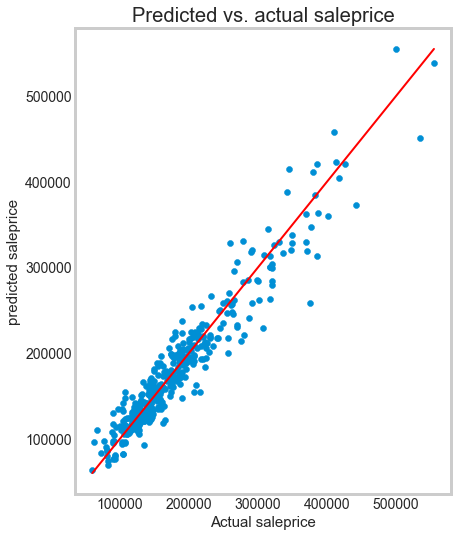

In [31]:
# production model
# scatterplot to show predicted saleprice versus actual saleprice

# find y_pred
pm_y_pred = lasso.predict(X_test_scaled)
pm_y_pred = np.exp(pm_y_pred)
y_test = np.exp(y_test)
plt.figure(figsize=(6,8))
plt.scatter(y_test, pm_y_pred)

p1 = max(max(y_test), max(pm_y_pred))
p2 = min(min(y_test), min(pm_y_pred))
plt.plot([p1, p2], [p1, p2], color = 'red', linewidth = 2)
plt.title('Predicted vs. actual saleprice')
plt.xlabel('Actual saleprice', fontsize=15)
plt.ylabel('predicted saleprice', fontsize=15)
plt.grid(False)
plt.show()

### Production model limitations

As observed above, there is a slight tradeoff between interpretability and accuracy. By decreasing the number of features input from 88 to 28, we have greatly increased the simplicity and interpretability of our model, but this also resulted in a slight decrease in R^2 (R^2 score indicates the percentage of how much the dependent variable is explained by changes in independent variables). However, I chose to proceed with the production model because despite the testing R^2 score of our production model decreasing by 0.7% compared to our original model, I was able to decrease the total number of features by 300%. Therefore, I would gladly take this tradeoff.

Another limitation when building the model was that domain knowledge is required when deciding whether to convert nominal categories to ordinal, especially when looking at materials. For example, for `fence`, it is difficult to determine the rank of `privacy`, material and `no fence` or if one hot encoding it should be a fairer way. Hence, domain knowledge here was important  in which we would know if house buyers would deem which value as more valuable to them.

## Kaggle Submission
---

Use production model to predict SalePrice for test set.

In [32]:
# import cleaned test set
test_df = pd.read_csv('../datasets/test_final_dummy.csv')

In [33]:
# input (2-D)
X = test_df[production_features]
X.shape

(878, 28)

In [34]:
# scale 
X_scaled = ss.fit_transform(X)

In [35]:
# y predict
test_y_pred = lasso.predict(X_scaled)

# convert y predict back to saleprice
test_y_pred = np.exp(test_y_pred)

# view first 10 values to check for successful conversion
print(test_y_pred[:10].round(2))

# view total number of observations, it should = 878
len(test_y_pred)

[137317.37 168772.62 202484.41 105674.33 167950.29  98172.81 111859.43
 177764.39 189123.59 171899.69]


878

### Create Kaggle submission file format (.csv)
---

The Kaggle score (RMSE) for the production model was **22525.28** .

In [36]:
original_test = pd.read_csv('../datasets/test.csv')
submission = original_test[['Id']]
submission['SalePrice'] = test_y_pred
submission.head(10)

<ipython-input-36-b751399f96bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['SalePrice'] = test_y_pred


Id      SalePrice
0  2658  137317.366214
1  2718  168772.621060
2  2414  202484.410688
3  1989  105674.329842
4   625  167950.285388
5   333   98172.808893
6  1327  111859.428557
7   858  177764.393349
8    95  189123.586238
9  1568  171899.688602

In [37]:
# export csv for submission in to Kaggle
submission.to_csv('../datasets/kaggle_submission.csv', index = False)

## Interpretation and insights
---

### Feature coefficient analysis

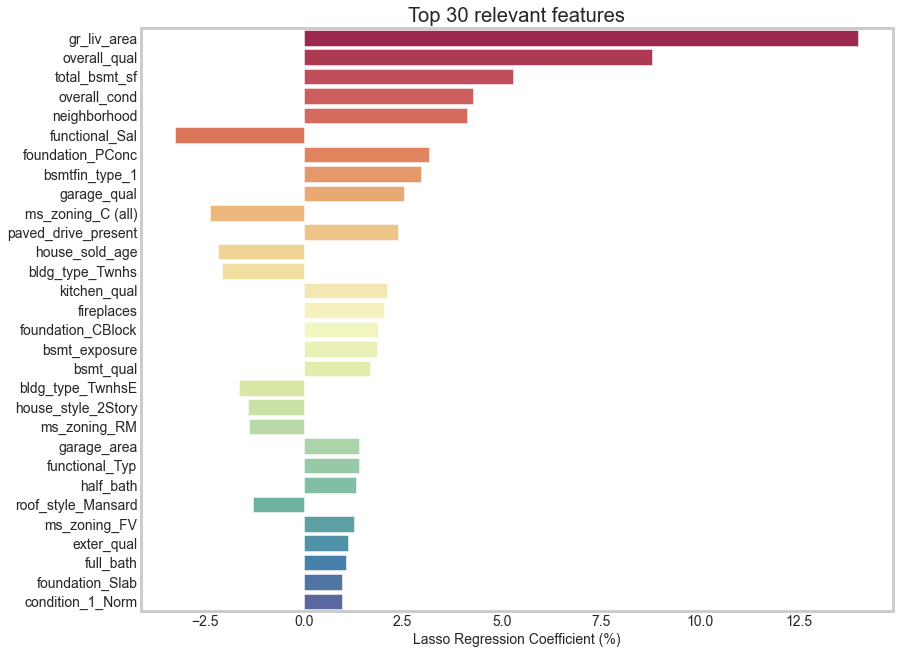

In [38]:
# Full plot of top 30 features wrt lasso coefficients
plt.figure(figsize= (12,10))
data = lasso_df[['Feature','Coef (%)']].head(30)
ax = sns.barplot(data=data, y='Feature', x = 'Coef (%)', orient='h', palette = 'Spectral')
ax.set_ylabel('')
ax.set_xlabel('Lasso Regression Coefficient (%)', fontsize = 14)
plt.grid(False)
plt.title('Top 30 relevant features')
plt.show()

As seen on the bar chart above, **area** and **quality** of the house in general seems to be the biggest contributor to value of housing. Hence, a per unit increase in area of the house would cause a much greater percentage increase in the house price compare to other features. This is the same for quality / condition of the house, in which the better the quality / material used, the house price would increase to a greater extent as compared to other features.

We will be zooming into the features below when giving [business recommendations to management](#Business-recommendations-to-management) in relation to house flipping:

<u>Area features</u>:
- gr_liv_area
- total_bsmt_sf
- paved_drive_present

<u>Quality features</u>:
- overall_qual
- over_cond
- foundation_PConc
- bsmtfin_type_1
- garage_qual

### Neighborhood analysis

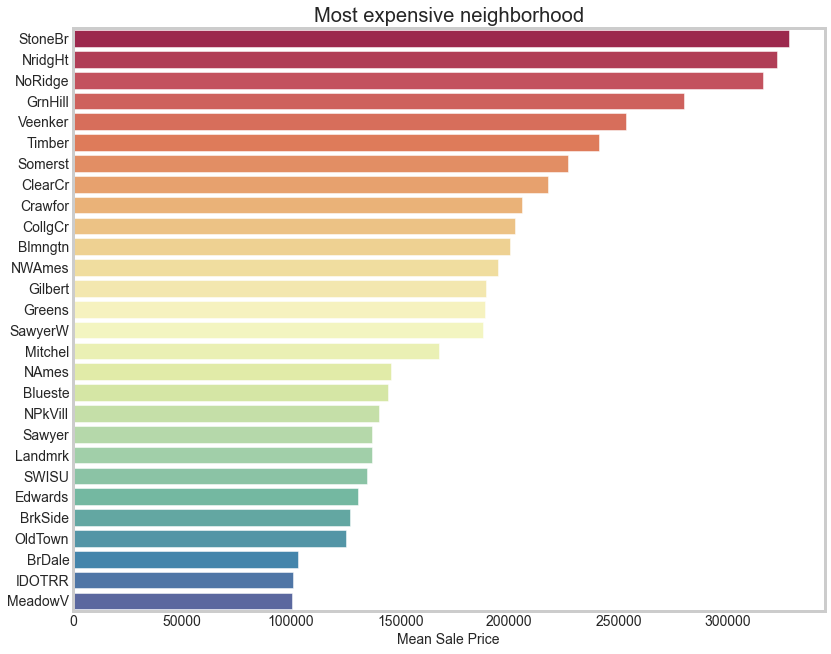

In [39]:
# visualise neighborhood based on mean saleprice
train_final = pd.read_csv('../datasets/train_cleaned.csv')
nbhd = train_final.groupby('neighborhood', as_index=True)['saleprice'].mean().sort_values(ascending=False)
nbhd_df = pd.DataFrame({'neighborhood': nbhd.index,
                       'mean_saleprice': nbhd})

# plot horizontal bar chart to visualize
plt.figure(figsize= (12,10))
ax = sns.barplot(data=nbhd_df, x = 'mean_saleprice',y='neighborhood',orient='h', palette = 'Spectral')
ax.set_ylabel('')
ax.set_xlabel('Mean Sale Price', fontsize = 14)
plt.grid(False)
plt.title('Most expensive neighborhood')
plt.show()

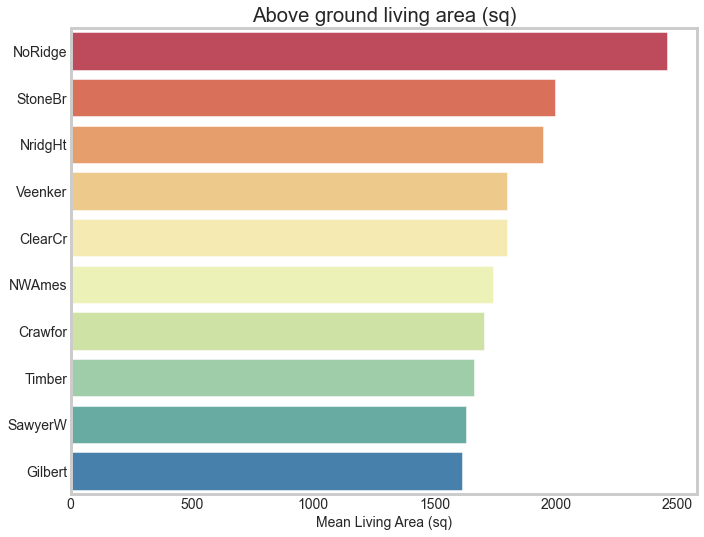

In [40]:
# visualise neighborhood based on gr_liv_area
nbhd_area = train_final.groupby('neighborhood', as_index=True)['gr_liv_area'].mean().sort_values(ascending=False)
nbhd_area_df = pd.DataFrame({'neighborhood': nbhd_area.index,
                       'mean_gr_liv_area': nbhd_area})

# plot horizontal bar chart to visualize
plt.figure(figsize= (10,8))
ax = sns.barplot(data=nbhd_area_df.head(10), x = 'mean_gr_liv_area',y='neighborhood',orient='h', palette = 'Spectral')
ax.set_ylabel('')
ax.set_xlabel('Mean Living Area (sq)', fontsize = 14)
plt.grid(False)
plt.title('Above ground living area (sq)')
plt.show()

Given that `neighborhood` is one of our Top 5 Features based on Lasso Regression Coefficient, it is therefore one of the features that would give the greatest increase in sale price. 

To address our problem statement, in order to flip houses for a profit, the company should look into the 3 most expensive neighborhoods, namely `StoneBr` (Stone Brook), `NridgHt` (Northridge Heights), and `NoRidge` (Northridge).

- Firstly, the company should avoid buying the property if its predicted sale price exceeds the respective mean sales price. 
- Secondly, if predicted sales prices are approximately below $300,000, then the property is most likely undervalued. Management should look into the **area** and **quality** features as mentioned [above](#Feature-coefficient-analysis) to determine which of the undervalued properties would give the most return on investment (ROI).
- It is recommended for management to focus more attention into finding undervalued properties in `NoRidge` among the other two previously stated, as houses in NoRidge are generally larger in size. Hence, management could purchase an undervalued house in NoRidge, expand the house to be one of the larger houses in the neighborhood (bearing in mind that 1 sq increase in above ground living area results in a 14 percent increase in saleprice) and sell the house for a much higher profit.

## Business recommendations to management
---

Based on our model, our company looking to flip undervalued houses and sell them for a profit could focus on the following during the renovation (i.e. flipping) process:

- Improve the overall quality of material and finish of the house
- Improve the overall condition of the house ( e.g. repainting and upkeeping )
- The foundation of the house should be 'Poured Concrete'
- Improve the basement finished area ( * do not let it go unfinished )
- Renovate the garage if it is in bad condition ( * add a garage if there isn't one )
- Add a paved driveway
- Add a fireplace

In terms of choosing which house to flip (i.e. location of house) :
- It is recommended for management to focus more attention into finding undervalued properties in NoRidge, as houses in NoRidge are generally larger in size. Hence, management could purchase an undervalued house in NoRidge, expand the house to be one of the larger houses in the neighborhood (bearing in mind that 1 sq increase in above ground living area results in a 14 percent increase in saleprice) and sell the house for a much higher profit


<u>Do the team feel that this model will generalize to other cities? How could the team revise the model to make it more universal?</u>

Ames trend:
![](../pictures/ames_trend.png)

US general trend:
![](../pictures/general_trend.png)


The city of Ames do display trends that are in line with the majority of the cities. One example is the trend of housing prices even during the **subprime mortgage crisis of 2008**.

**However**, one point to keep in mind that the last date recorded was in 2010 and there are not enough recent data to determine that Ames saleprice trend is still the same as the general US cities trend due to various factors such as housing policy changes, recession economy and COVID'19. Hence, the team do feel that this model may be applicable to a certain extent when using on other cities in the United States. 

In order to revise the model to make it more universal, the simplest say would be to collect more recent data (2011-2021), preferably from other cities as well such as Los Angeles and New York, and create a model with a time period of 2000 - 2021. More universal features could also be added into the new data such as 'high rise buildings', 'elevators' and 'centralise carparks'.

## Appendix

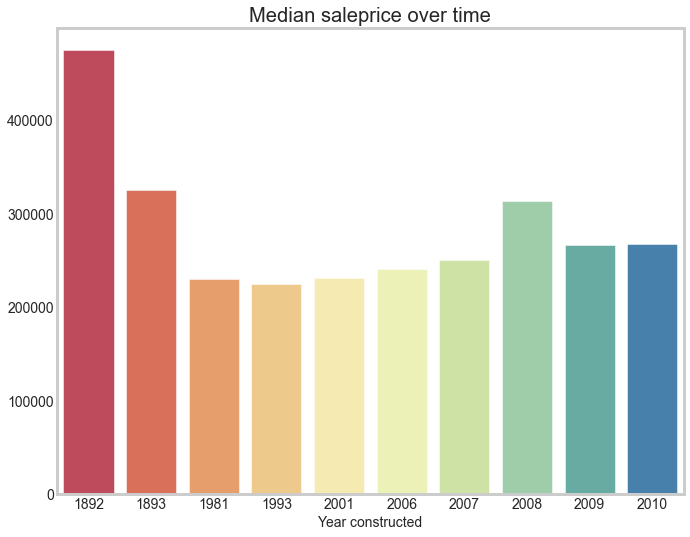

In [41]:
# visualise saleprice based on yr_built
sale_year = train_final.groupby('year_built', as_index=True)['saleprice'].median().sort_values(ascending=False)
sale_year_df = pd.DataFrame({'year_built': sale_year.index,
                       'median_saleprice': sale_year})
plt.figure(figsize= (10,8))
ax = sns.barplot(data=sale_year_df.head(10), x = 'year_built',y='median_saleprice', palette = 'Spectral')
ax.set_ylabel('')
ax.set_xlabel('Year constructed', fontsize = 14)
plt.grid(False)
plt.title('Median saleprice over time')
plt.show()

<Figure size 1080x1080 with 0 Axes>

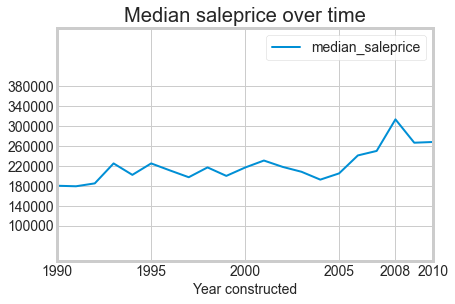

In [42]:
# visualise saleprice based on yr_built
sale_year = train_final.groupby('year_built', as_index=True)['saleprice'].median().sort_values(ascending=False)
sale_year_df = pd.DataFrame({'year_built': sale_year.index,
                       'median_saleprice': sale_year})
sale_year_df.reset_index(drop=True,inplace=True)
sale_year_df=sale_year_df.sort_values(by='year_built')
sale_year_df.head(30)
plt.figure(figsize= (15,15))
sale_year_df.plot(x = 'year_built', y = 'median_saleprice', kind = 'line', linewidth = 2)
plt.ylabel('')
plt.xlabel('Year constructed', fontsize = 14)
plt.xlim(1990,2010)
x= [1990,1995,2000,2005,2008,2010]
plt.xticks(x)
plt.yticks(np.arange(100_000,400_000,40_000))
# plt.grid(False)
plt.title('Median saleprice over time')
plt.show()

<s><u>**Step 2**</u>

As the features in the dataset should conform to the statistical assumptions of the models, in the case of Linear Regression, it should follow more or less a normal distribution. We will be using `PowerTransformer` which applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. By default, PowerTransformer applies zero-mean, unit variance normalization. <sup>[(1)](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)</sup>

As StandardScaler cannot guarantee balanced feature scales in the presence of outliers (i.e. more weight given to outliers). Hence, we will be replacing it with PowerTransformer.<s>

In [43]:
# # power transform
# pt = PowerTransformer()

# X_train_power = pt.fit_transform(X_train)
# X_test_power = pt.transform(X_test)

In [44]:
# # fit training data to lasso model with PowerTransformer
# lasso.fit(X_train_power,y_train)

In [45]:
# # calculate R^2 (non-CVS) with PowerTransformer
# print("Training R2(Lasso) ", lasso.score(X_train_power,y_train))
# print("Testing R2(Lasso):", lasso.score(X_test_power,y_test))

In [46]:
# # calculate RMSE (non-CVS) with PowerTransformer
# print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_power))))
# print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_power))))